In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import time

## Model Configuration

In [2]:
from dataclasses import dataclass
from typing import Optional

@dataclass
class ModelArgs:
    dim: int = 128
    n_layers: int = 2
    n_heads: int = 4
    n_kv_heads: Optional[int] = None
    vocab_size: int = -1  # defined later by tokenizer
    multiple_of: int = 256  # make SwiGLU hidden layer size multiple of large power of 2
    ffn_dim_multiplier: Optional[float] = None
    norm_eps: float = 1e-5

    max_batch_size: int = 32
    max_seq_len: int = 16 * 4

    epochs: int = 10_000    

model_config = ModelArgs()
print(model_config)

ModelArgs(dim=128, n_layers=2, n_heads=4, n_kv_heads=None, vocab_size=-1, multiple_of=256, ffn_dim_multiplier=None, norm_eps=1e-05, max_batch_size=32, max_seq_len=64, epochs=10000)


## Prepare Data

In [3]:
# simple tokenization by characters
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])


lines = open('./data/Shakespeare.txt', 'r').read()
vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}
dataset = torch.tensor(encode(lines), dtype=torch.int8)
print(f'Sentences: {dataset.shape[0]}')

model_config.vocab_size = len(vocab)

def get_batches(data, split, batch_size, context_window):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    if split == 'train':
        batch_data = train
    elif split == 'test':
        batch_data = test
    else:
        batch_data = val

    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

Sentences: 1115394


In [4]:
dataset.shape

torch.Size([1115394])

## Define Models

### RMS Normalization 

- [Paper](https://arxiv.org/pdf/1910.07467.pdf)
- [Reference implementation](https://github.com/facebookresearch/llama/blob/54d44631054deae836aec8ceff92dcf8f20ca9e7/llama/model.py#L34)

In [5]:
class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        """
        Initialize the RMSNorm normalization layer.

        Args:
            dim (int): The dimension of the input tensor.
            eps (float, optional): A small value added to the denominator for numerical stability. Default is 1e-6.

        Attributes:
            eps (float): A small value added to the denominator for numerical stability.
            weight (nn.Parameter): Learnable scaling parameter.

        """
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x : torch.tensor) -> torch.tensor:
        """
        Apply the RMSNorm normalization to the input tensor.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The normalized tensor.

        """
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x) -> torch.tensor:
        """
        Forward pass through the RMSNorm layer.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor after applying RMSNorm.

        """        
        return self._norm(x.float()).type_as(x) * self.weight

### RoPE

- [Paper](https://arxiv.org/pdf/2104.09864.pdf)
- [Reference Implementation](https://github.com/facebookresearch/llama/blob/dccf644213a2771a81fc4a754eed9623ea7f8444/llama/model.py#L80)

In [6]:
class RoPE:
    def __init__(self, dim: int, max_seq_len: int, theta: float = 10000.0):
        """
        Precompute the frequency tensor for complex exponentials (cis, defined as 'm*theta_i' in the paper) 
        with given dimensions.

        Calculates a frequency tensor with complex exponentials using the given dimension 'dim'
        and the max sequence length. The 'theta_base' parameter scales the frequencies.
        The returned tensor contains complex values in complex64 data type.

        Args:
            dim (int): Dimension of the frequency tensor.
            max_seq_len (int): Max sequence length.
            theta_base (float, optional): Scaling factor for frequency computation. Defaults to 10000.0.
        """
        freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
        freqs = torch.outer(torch.arange(max_seq_len), freqs).float()
        self.freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
        print(f"Rope Initialized! dim:{dim} max_seq_len:{max_seq_len}")
        
    def __call__(self, x: torch.Tensor, start_pos = 0) -> torch.Tensor:
        """
        Apply rotary embeddings to input tensors using the given frequency tensor.

        This function first reshapes the frequency tensor to have the same shape as the target tensor 'x'
        for the purpose of broadcasting the frequency tensor during element-wise operations. Then, it applies 
        rotary embeddings to 'x' tensor using frequency tensor 'freqs_cis'.         
        """
        x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))

        shape = [d if i == 1 or i == x.ndim - 1 else 1 for i, d in enumerate(x_complex.shape)]
        freqs_cis = self.freqs_cis[start_pos:start_pos + x.shape[-2]].view(*shape)
                
        x_real = torch.view_as_real(x_complex * freqs_cis).flatten(-2)
        
        return x_real.type_as(x)

#### RoPE Test

In [7]:
dim = 128
max_seq_len = 256

def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    for position in range(context_window):
        for i in range(embedding_dim//2):
            theta = 10000. ** (-2.*i / embedding_dim)
            m_theta = position * theta
            R[position, 2*i,2*i] = np.cos(m_theta)
            R[position, 2*i,2*i+1] = - np.sin(m_theta)
            R[position, 2*i+1,2*i] = np.sin(m_theta)
            R[position, 2*i+1,2*i+1] = np.cos(m_theta)
    return R

R = get_rotary_matrix(max_seq_len, dim)

X= torch.ones(1, max_seq_len, dim)
rope = RoPE(dim=dim, max_seq_len=max_seq_len)
X1 = rope(X)
X2 = (R @ X.unsqueeze(-1)).flatten(-2)

print(X1.allclose(X2, atol=1e-3))


Rope Initialized! dim:128 max_seq_len:256
True


### Attention

In [8]:
class Attention(nn.Module):
    shared_rope : RoPE = None

    def __init__(self, config : ModelArgs):
        super().__init__()
        self.config = config
        if Attention.shared_rope is None:
            Attention.shared_rope = RoPE(config.dim, config.max_seq_len)

        self.w_q = nn.Linear(config.dim, config.dim, bias=False)
        self.w_k = nn.Linear(config.dim, config.dim, bias=False)
        self.w_v = nn.Linear(config.dim, config.dim, bias=False)
        self.cache_k = torch.zeros(config.max_batch_size, config.max_seq_len, config.dim)
        self.cache_v = torch.zeros_like(self.cache_k)

    def forward(self, x: torch.tensor, start_pos : int) -> torch.tensor:
        # print(f'start_pos: {start_pos} \n x: {x[:,:,:5]}')
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q = Attention.shared_rope(q, start_pos)
        k = Attention.shared_rope(k, start_pos)

        if self.training:       # apply dropout only during training
            dropout_p = .1
        else:
            self.cache_k[:, start_pos:start_pos + x.shape[-2]] = k
            self.cache_v[:, start_pos:start_pos + x.shape[-2]] = v        
            k = self.cache_k[:, :start_pos + x.shape[-2]]
            v = self.cache_v[:, :start_pos + x.shape[-2]]
            
            dropout_p = 0
                
        activations = F.scaled_dot_product_attention(
            q, k, v, dropout_p = dropout_p, is_causal=True
        )

        return activations


class MultiheadAttention(nn.Module):
    def __init__(self, config: ModelArgs):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            Attention(config) for _ in range(config.n_heads)
        ])
        self.linear = nn.Linear(config.n_heads * config.dim, config.dim)
        self.dropout = nn.Dropout(.1)

    def forward(self, x : torch.tensor, start_pos : int) -> torch.tensor:
        heads = [h(x, start_pos) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x

In [9]:
from collections import OrderedDict

class SwiGLU(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)

        self.beta = torch.ones(1, requires_grad=True)

    def forward(self, x): 
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

class LlamaBlock(nn.Module):
    def __init__(self, config: ModelArgs):
        super().__init__()
        self.config = config

        self.rms = RMSNorm(config.dim)

        self.attention = MultiheadAttention(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config.dim, config.dim),
            SwiGLU(config.dim),
        )

    def forward(self, x, start_pos) -> torch.tensor:
        x = self.rms(x) # rms pre-normalization
        x = x + self.attention(x, start_pos)

        x = self.rms(x) # rms pre-normalization
        x = x + self.feedforward(x)
        return x

class Llama(nn.Module):
    def __init__(self, config: ModelArgs):
        super().__init__()
        self.config = config
        self.embeddings = nn.Embedding(config.vocab_size, config.dim)
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"LlamaBlock_{i}", LlamaBlock(config)) for i in range(config.n_layers)])
        )

        self.ffn = nn.Sequential(
            nn.Linear(config.dim, config.dim),
            SwiGLU(config.dim),
            nn.Linear(config.dim, config.vocab_size),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, start_pos = 0, targets = None):
        x = self.embeddings(idx)
        for block in self.llama_blocks:
            x = block(x, start_pos)
        logits = self.ffn(x)

        if targets is None:
            return logits
        else:
            loss = F.cross_entropy(logits.view(-1, self.config.vocab_size), targets.view(-1))
            return logits, loss

## Training

In [10]:
@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss(model:Llama):
    config = model.config
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config.max_batch_size, config.max_seq_len)
            _, loss = model(xb, 0, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

def train(model: Llama, optimizer:torch.optim.Optimizer, scheduler = None, print_logs = False, log_interval = 100):
    losses = []
    start_time = time.time()
    config = model.config
    for epoch in range(config.epochs):
        optimizer.zero_grad()

        xs, ys = get_batches(dataset, 'train', config.max_batch_size, config.max_seq_len)
        _, loss = model(xs, 0, ys)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        if epoch % log_interval == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config.epochs - epoch)/log_interval :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())

    # print(pd.DataFrame(losses))
    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()

Rope Initialized! dim:128 max_seq_len:64
model params: 690113
Epoch 0 | val loss 4.157 | Time 0.093 | ETA in seconds 9.301
Epoch 100 | val loss 2.277 | Time 4.854 | ETA in seconds 480.500
Epoch 200 | val loss 2.074 | Time 4.706 | ETA in seconds 461.171
Epoch 300 | val loss 1.995 | Time 4.638 | ETA in seconds 449.871
Epoch 400 | val loss 1.951 | Time 4.618 | ETA in seconds 443.362
Epoch 500 | val loss 1.886 | Time 5.183 | ETA in seconds 492.339
Epoch 600 | val loss 1.861 | Time 5.365 | ETA in seconds 504.303
Epoch 700 | val loss 1.813 | Time 5.948 | ETA in seconds 553.142
Epoch 800 | val loss 1.813 | Time 6.272 | ETA in seconds 577.047
Epoch 900 | val loss 1.819 | Time 7.348 | ETA in seconds 668.707
Epoch 1000 | val loss 1.796 | Time 6.348 | ETA in seconds 571.332
Epoch 1100 | val loss 1.774 | Time 7.038 | ETA in seconds 626.403
Epoch 1200 | val loss 1.767 | Time 7.286 | ETA in seconds 641.168
Epoch 1300 | val loss 1.743 | Time 6.638 | ETA in seconds 577.516
Epoch 1400 | val loss 1.752 

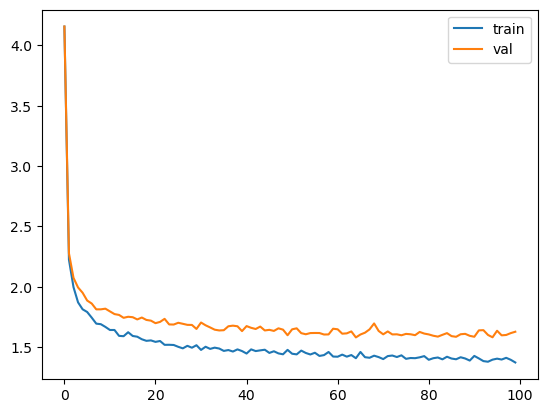

In [11]:
%%time

from datetime import datetime

llama = Llama(model_config)
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer, print_logs=True)

# Save
now = datetime.now()
model_name = f'./checkpoint/llama_{now.year}_{now.month}_{now.day}_{now.hour}_{now.minute}.pth'
torch.save({'model_state_dict': llama.state_dict()}, model_name)

## Generate

In [12]:
@torch.no_grad()
def generate(model : Llama, max_new_tokens = 10):
    model.eval()
    config = model.config
    max_new_tokens = model.config.max_seq_len if max_new_tokens > model.config.max_seq_len else max_new_tokens
    idx = torch.zeros(config.max_batch_size, 1).long()

    start_pos = 0
    for i in range(max_new_tokens):
        # print(i)
        if i == 0:
            logits = model(idx)
        else:
            # logits = model(idx[:, -1].unsqueeze(-1), start_pos)
            logits = model(idx[:, -config.max_seq_len:], 0)
        
        last_time_step_logits = logits[:, -1, :]            # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)        # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )                                                   # sample from the distribution to get the next token

        start_pos = idx.shape[-1]
        idx = torch.cat([idx, idx_next], dim=-1)            # append to the sequence
                    
    return [decode(x) for x in idx.tolist()]

In [15]:
%%time

import glob
import os

## Get lastest checkpoint
files = glob.glob('./checkpoint/*.pth')
files.sort(key=os.path.getmtime)
model_name = files[-1]

model_config.max_batch_size = 1
Attention.shared_rope = None

llama_infer = Llama(model_config)
llama_infer.load_state_dict(torch.load(model_name)['model_state_dict'])

# torch.manual_seed(42)
print(generate(llama_infer, 160)[0])

Rope Initialized! dim:128 max_seq_len:64
model params: 690113

The manabled approud cheque done? for in then breathest?
Ah, fro
CPU times: user 1.3 s, sys: 10 ms, total: 1.31 s
Wall time: 143 ms


In [14]:
Attention.shared_rope = None